In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as c
from astropy import units as u
from matplotlib.pyplot import cycler
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.cm
from matplotlib import patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as st

In [2]:
def get_cycle(cmap, N=None, use_index="auto"):
    if isinstance(cmap, str):
        if use_index == "auto":
            if cmap in ['Pastel1', 'Pastel2', 'Paired', 'Accent',
                        'Dark2', 'Set1', 'Set2', 'Set3',
                        'tab10', 'tab20', 'tab20b', 'tab20c']:
                use_index=True
            else:
                use_index=False
        cmap = plt.get_cmap(cmap)
    if not N:
        N = cmap.N
    if use_index=="auto":
        if cmap.N > 100:
            use_index=False
        elif isinstance(cmap, LinearSegmentedColormap):
            use_index=False
        elif isinstance(cmap, ListedColormap):
            use_index=True
    if use_index:
        ind = np.arange(int(N)) % cmap.N
        return cycler("color",cmap(ind))
    else:
        colors = cmap(np.linspace(0,1,N))
        return cycler("color",colors)

In [3]:
c.G

<<class 'astropy.constants.codata2018.CODATA2018'> name='Gravitational constant' value=6.6743e-11 uncertainty=1.5e-15 unit='m3 / (kg s2)' reference='CODATA 2018'>

In [4]:
a = 1*(1/u.yr)
if not hasattr(a,'unit'):
    a = a*u.Hz
elif a.unit is not u.Hz:
    a = a.to(u.Hz)
a

<Quantity 3.16880878e-08 Hz>

In [5]:
def dt_by_f(f_gw,mc,units_out=u.yr):
    '''
    Returns delta_t = t_c - t (time to coalescence t_c)
    
    Assumes f_gw in Hz, mc in Msun.
    
    units_out (astropy.unit) must be a time unit; result will be returned in these units (default yrs)
    '''
    ## unit checking
    if not hasattr(f_gw,'unit'):
        f_gw = f_gw*u.Hz
    elif f_gw.unit is not u.Hz:
        f_gw = f_gw.to(u.Hz)
    
    if not hasattr(mc,'unit'):
        mc = mc*u.M_sun
        mc = mc.to(u.kg)
    elif mc.unit is not u.kg:
        mc = mc.to(u.kg)
    
    return ((5/(8*np.pi)**(8/3)) * (c.G*mc/c.c**3)**(-5/3) * f_gw**(-8/3)).decompose().to(units_out)

In [6]:
def f_by_dt(dt,mc,units_in=u.yr):
    '''
    Inverse of above. dt = t_c - t (i.e., time to coalescence)
    '''
    if not hasattr(dt,'unit'):
        dt = dt*units_in.to(u.s)
    elif dt.unit is not u.s:
        dt = dt.to(u.s)
    
    if not hasattr(mc,'unit'):
        mc = mc*u.M_sun
        mc = mc.to(u.kg)
    elif mc.unit is not u.kg:
        mc = mc.to(u.kg)
    
    return ((5**(3/8) / (8*np.pi)) * (c.G*mc/c.c**3)**(-5/8) * dt**(-3/8)).decompose().to(u.Hz)

In [7]:
f_by_dt(205026*u.yr,1e7*u.M_sun)

<Quantity 1.00000138e-07 Hz>

In [8]:
dt_by_f(1e-7,10**7)

<Quantity 205026.75403065 yr>

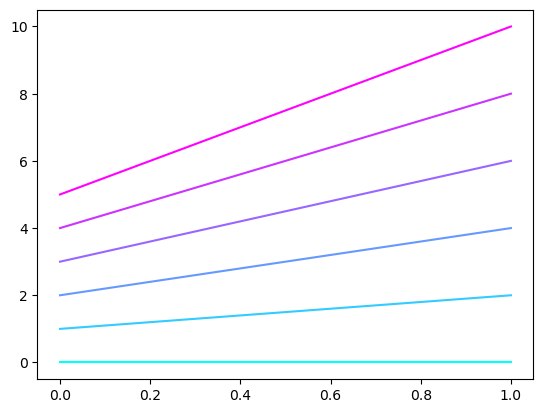

In [9]:
import matplotlib.pyplot as plt
N = 6
plt.rcParams["axes.prop_cycle"] = get_cycle("cool", N)

fig, ax = plt.subplots()
for i in range(N):
    ax.plot([0,1], [i, 2*i])

plt.show()

## Pulsar distance range for PTA "echo"

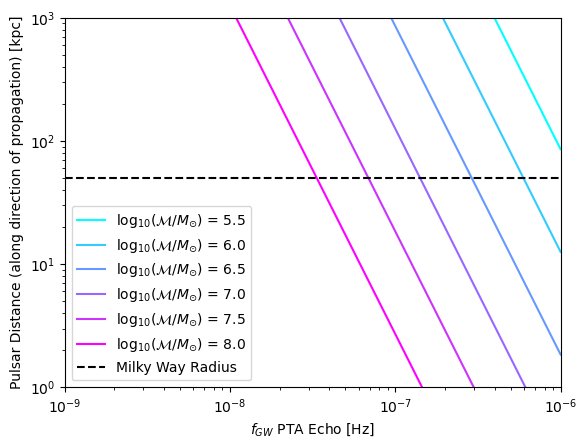

In [10]:
fs = 10.0**np.arange(-10,-5)
ms = np.logspace(5.5,8,6)
plt.rcParams["axes.prop_cycle"] = get_cycle("cool", len(ms))
plt.figure()
for m in ms:
    plt.loglog(fs,np.array([2*(dt_by_f(f0,m,units_out=u.s)*c.c).to(u.kpc).value for f0 in fs]),
               label="$\\mathrm{log}_{10}(\\mathcal{M}/M_{\\odot})$ ="+" {:0.1f}".format(np.log10(m)))
plt.axhline(50,ls='--',c='k',label='Milky Way Radius')
plt.ylabel('Pulsar Distance (along direction of propagation) [kpc]')
plt.xlabel('$f_{GW}$ PTA Echo [Hz]')
plt.ylim(1,1000)
plt.xlim(1e-9,1e-6)
plt.legend(loc='lower left')
plt.show()

## (V. approximate) LISA detectability of corresponding mass ranges:

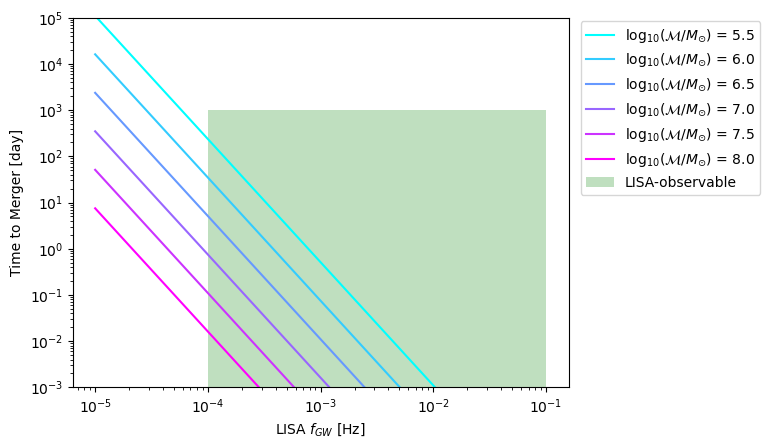

In [11]:
fs_lisa = np.logspace(-5,-1,100)
plt.figure()
for m in ms:
    plt.loglog(fs_lisa,np.array([dt_by_f(f0,m,units_out=u.day).value for f0 in fs_lisa]),
               label="$\\mathrm{log}_{10}(\\mathcal{M}/M_{\\odot})$ ="+" {:0.1f}".format(np.log10(m)))
# plt.axhline(50,ls='--',c='k',label='Milky Way Radius')
plt.gca().add_patch(patches.Rectangle((1e-4,1e-3),1e-1,1e3,facecolor='green',alpha=0.25,label='LISA-observable'))
plt.ylabel('Time to Merger [day]')
plt.xlabel('LISA $f_{GW}$ [Hz]')
# plt.ylim(1,1000)
plt.ylim(1e-3,1e5)
plt.legend(bbox_to_anchor=(1.01,1.01))
plt.show()

## Back-of-the-napkin time-delay map

In [12]:
49.5/50

0.99

In [13]:
extent = 5

In [14]:
## random-ish distances and phis
N_pulsar = 80
rng = np.random.default_rng(170817)
phis = st.uniform.rvs(0,2*np.pi,size=N_pulsar,random_state=rng)
rs = st.beta.rvs(3,1,scale=0.99*extent,size=N_pulsar) ## this is a p(r) ~ r**2 dist

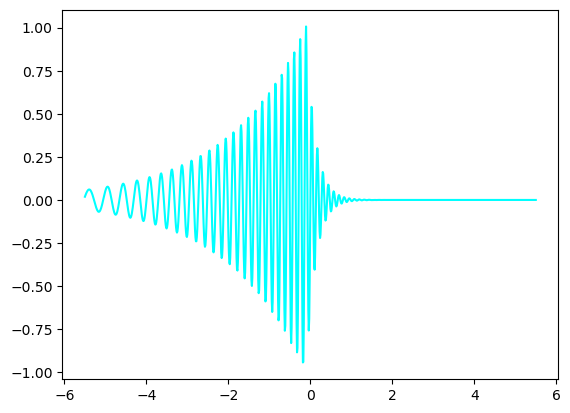

In [15]:
## silly little schematic waveform
plot_waveform_xs = np.linspace(-1.1*extent,1.1*extent,1000)
merger_x = -.1
damp_fac = np.array([1 if x<=merger_x else np.exp(-5*(x-merger_x)) for x in plot_waveform_xs])
plot_waveform_ys = 0.075*(1.7**(plot_waveform_xs+5))*np.sin(((plot_waveform_xs+15)*3) * plot_waveform_xs)\
                        *damp_fac
plt.figure()
plt.plot(plot_waveform_xs,plot_waveform_ys)
plt.show()

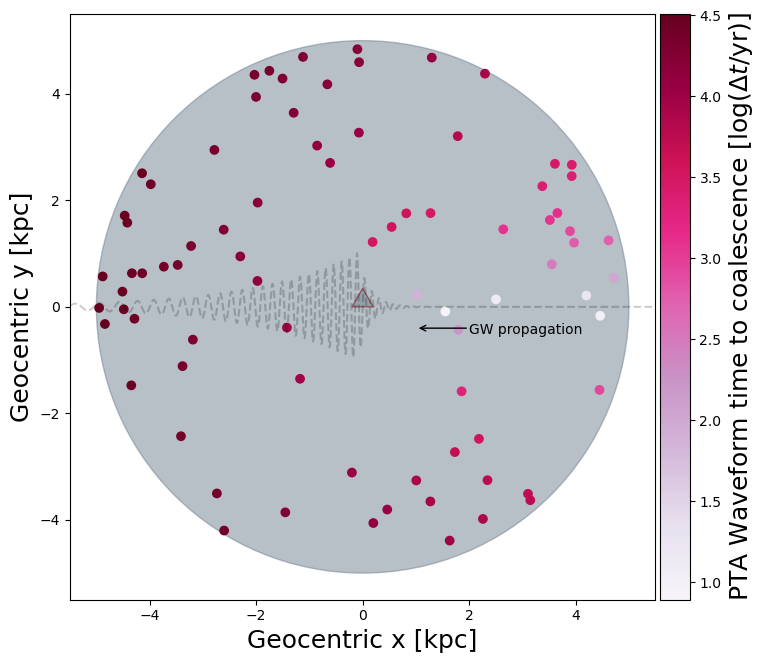

In [16]:

plot_extent = extent + 0.1*extent
plt.figure(figsize=(8,8))
plt.plot(plot_waveform_xs,plot_waveform_ys,color='k',alpha=0.2,ls='--')
plt.gca().annotate("", xytext=(2,-.4), xy=(1,-.4),
            arrowprops=dict(arrowstyle="->"))
plt.text(2,-.5,"GW propagation")
plt.gca().add_patch(patches.Circle((0,0),extent,color='slategrey',alpha=0.5))
plt.gca().add_patch(patches.Polygon(np.array([[0,0.2*np.sqrt(3)],[0.2,0],[-0.2,0]]),
                                    edgecolor='maroon',facecolor='slategrey',alpha=0.5))
plt.scatter(rs*np.cos(phis),rs*np.sin(phis),c=np.log10((rs*u.kpc/c.c).to(u.yr).value*(1-np.cos(phis))),
            cmap='PuRd')#,vmin=0,vmax=250000)
plt.xlim(-plot_extent,plot_extent)
plt.ylim(-plot_extent,plot_extent)
plt.xlabel("Geocentric x [kpc]",fontsize=18)
plt.ylabel("Geocentric y [kpc]",fontsize=18)
plt.gca().set_aspect('equal')
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label(label='PTA Waveform time to coalescence [log($\\Delta t$/yr)]',fontsize=18)
plt.show()

### Same plot, but PTA frequencies for a given merger

In [17]:
map_cmin = -7.5
map_cmax = -5

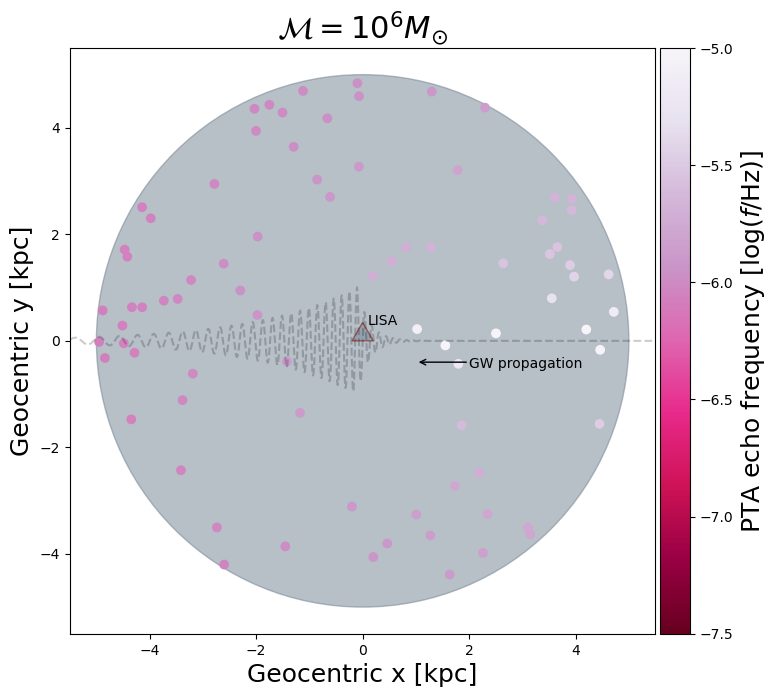

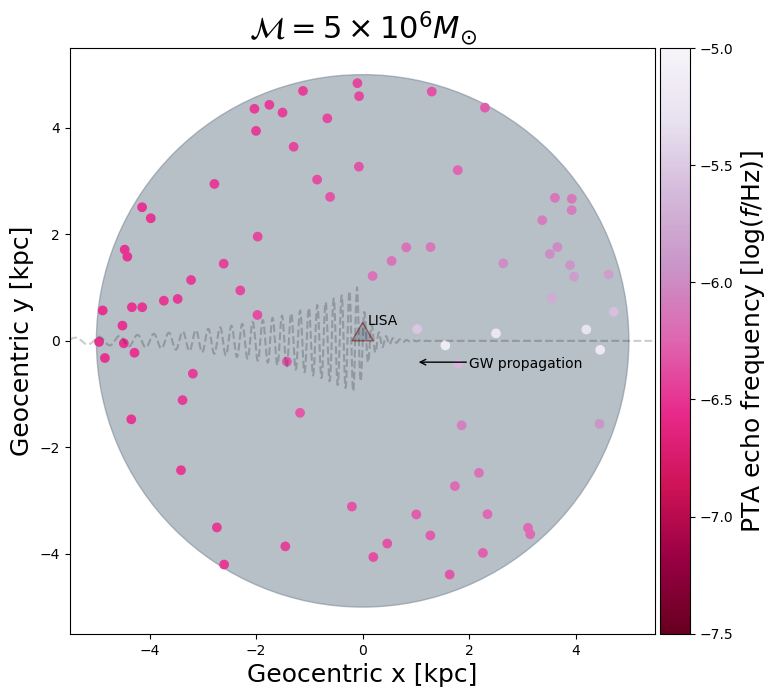

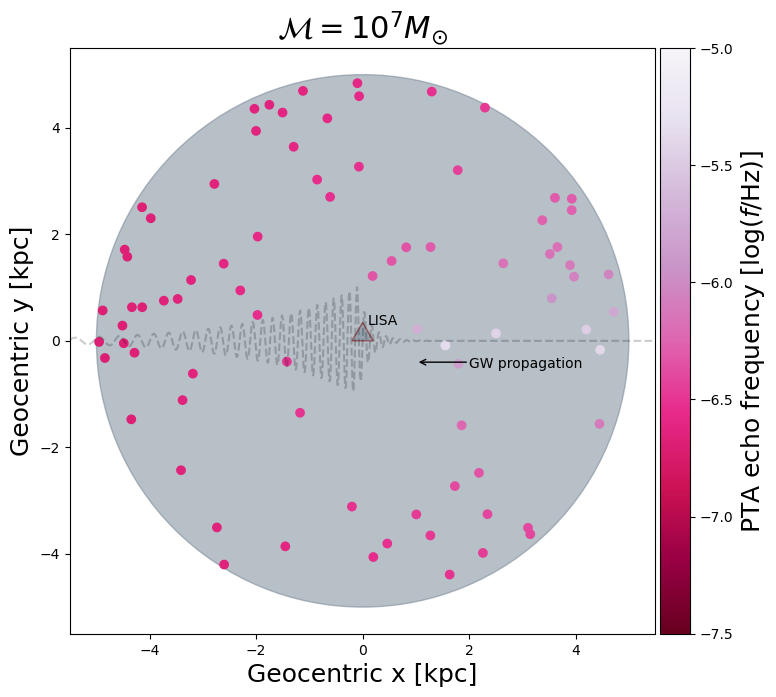

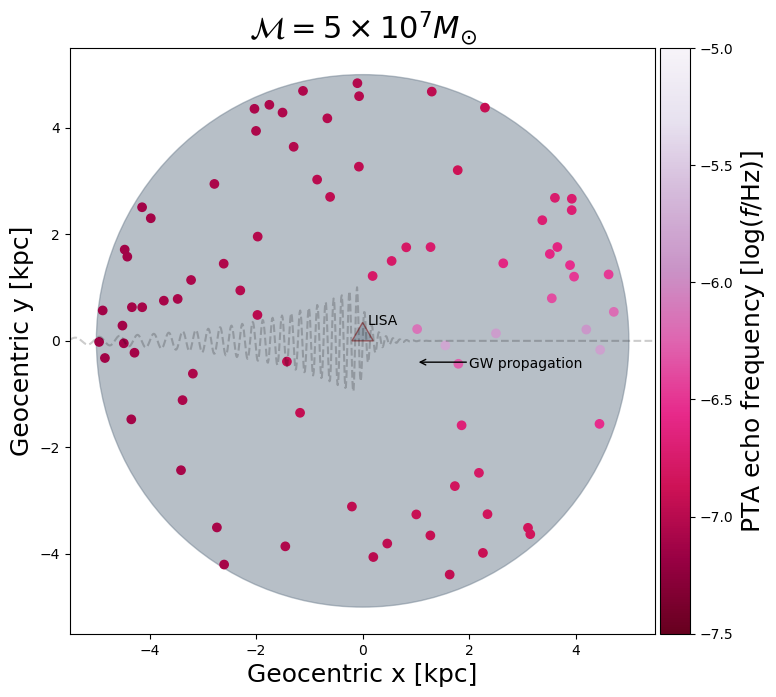

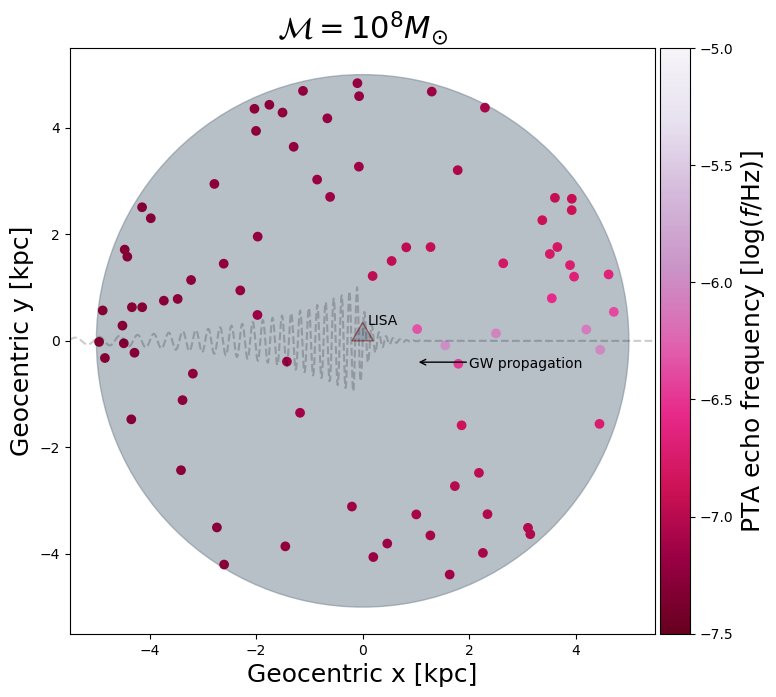

In [18]:
for mc, name in zip([1e6,5e6,1e7,5e7,1e8],["10^6",'5\\times10^6','10^7','5\\times10^7','10^8']):
    plot_extent = extent + 0.1*extent
    plt.figure(figsize=(8,8))
    plt.plot(plot_waveform_xs,plot_waveform_ys,color='k',alpha=0.2,ls='--')
    plt.gca().annotate("", xytext=(2,-.4), xy=(1,-.4),
                arrowprops=dict(arrowstyle="->"))
    plt.text(2,-.5,"GW propagation")
    plt.gca().add_patch(patches.Circle((0,0),extent,color='slategrey',alpha=0.5))
    plt.gca().add_patch(patches.Polygon(np.array([[0,0.2*np.sqrt(3)],[0.2,0],[-0.2,0]]),
                                    edgecolor='maroon',facecolor='slategrey',alpha=0.5))
    plt.text(.1,.3,"LISA")
    plt.scatter(rs*np.cos(phis),rs*np.sin(phis),
                c=np.log10(f_by_dt((rs*u.kpc/c.c).to(u.yr)*(1-np.cos(phis)),mc*u.M_sun).value),
                cmap='PuRd_r',vmin=map_cmin,vmax=map_cmax)
    plt.xlim(-plot_extent,plot_extent)
    plt.ylim(-plot_extent,plot_extent)
    plt.xlabel("Geocentric x [kpc]",fontsize=18)
    plt.ylabel("Geocentric y [kpc]",fontsize=18)
    plt.gca().set_aspect('equal')
    plt.title('$\\mathcal{M}='+name+' M_{\\odot}$',fontsize=22)
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(cax=cax)
    cb.set_label(label='PTA echo frequency [log($f$/Hz)]',fontsize=18)

    plt.show()